# Imports

Note:  
**LibriSpeech** is a corpus of approximately 1000 hours of 16Khz read English speech derived from read audiobooks from the LibriVox project.
**VoxForge** was set up to collect transcribed speech for use with Free and Open Source Speech Recognition Engines.  
**The TED-LIUM corpus** was made from audio talks and their transcriptions available on the TED website.  
**The Common Voice Dataset** (Mozilla) contains hundreds of thousands of voice samples that help developers build voice recognition tools.

In [1]:
import json
from pandas.io.json import json_normalize

import os
import regex as re
import string
import itertools

import numpy as np
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import nltk
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import jiwer
from jiwer import wer

import pickle

from sklearn.ensemble import RandomForestClassifier
#nltk.download('words')
import warnings
warnings.filterwarnings("ignore")

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', -1)

In [2]:
# own functions, placed in functions.py.
from functions import *

# Explore file structure

In [3]:
os.getcwd()

'/Users/oanaserban/propulsion_final_project/spinningbytes'

In [65]:
# What files do we have, how many? #160
path = 'dataset_new_asr_codes'
files = get_file_names(path)
#files = get_file_names(path, 'ami')
#len(files)
files

['ami_segmented_h__1_sagclg.json',
 'ami_segmented_h__1_sagplgp.json',
 'ami_segmented_h__2_ka.json',
 'ami_segmented_h__2_kl.json',
 'ami_segmented_h__3_mdagmlg.json',
 'ami_segmented_h__3_mdagrmlg.json',
 'ami_segmented_h__4_iabglbg.json',
 'ami_segmented_h__4_iaebglebg.json',
 'ami_segmented_h__5_a.json',
 'ami_segmented_h__5_ae.json',
 'ami_segmented_h__6_glvd.json',
 'ami_segmented_h__6_glvde.json',
 'ami_segmented_h__6_glvpce.json',
 'ami_segmented_h__6_glvve.json',
 'ami_segmented_h__7_macaglg.json',
 'ami_segmented_h__7_macaglge.json',
 'commonvoice__1_sagclg.json',
 'commonvoice__1_sagplgp.json',
 'commonvoice__2_ka.json',
 'commonvoice__2_kl.json',
 'commonvoice__3_mdagmlg.json',
 'commonvoice__3_mdagrmlg.json',
 'commonvoice__4_iabglbg.json',
 'commonvoice__4_iaebglebg.json',
 'commonvoice__5_a.json',
 'commonvoice__5_ae.json',
 'commonvoice__6_glvd.json',
 'commonvoice__6_glvde.json',
 'commonvoice__6_glvpce.json',
 'commonvoice__6_glvve.json',
 'commonvoice__7_macaglg.json

In [9]:
# What machines do we have, how many? #7
machines = get_machine_ids (files)
#len(machines)
machines

{'1', '2', '3', '4', '5', '6', '7'}

In [13]:
# What configurations do we have, how many? #26. Note the configurations ending in a number, what about them?
configurations = get_configurations (files)
configurations
#len(configurations)

{'1_sagclg',
 '1_sagclg88',
 '1_sagplgp',
 '1_sagplgp88',
 '2_ka',
 '2_ka81',
 '2_kl',
 '2_kl88',
 '3_mdagmlg',
 '3_mdagrmlg',
 '4_iabglbg',
 '4_iaebglebg',
 '4_iaengleng88',
 '4_ianglng88',
 '5_a',
 '5_a88',
 '5_ae',
 '5_ae88',
 '6_glvd',
 '6_glvde',
 '6_glvpce',
 '6_glvve',
 '7_macaglg',
 '7_macaglg88',
 '7_macaglge',
 '7_macaglge88'}

In [19]:
# What corpora do we have, how many? #10.
corpora = get_corpora (files)
corpora
#len(corpora)

{'ami_segmented_h',
 'commonvoice',
 'librispeech_clean',
 'librispeech_other',
 'rt_segmented_h',
 'st',
 'switchboard_segmented',
 'tedlium_segmented',
 'timit',
 'voxforge'}

In [21]:
# files for a certain corpora 
corpora = 'tedlium'
print('files in '+ corpora +':')
pprint([file for file in files if corpora in file])

# files for a certain machine 
machine = '1'
print('\nfiles produced by machine '+ machine +':')
pprint([file for file in files if machine in file])

files in tedlium:
['tedlium_segmented__1_sagclg.json',
 'tedlium_segmented__1_sagplgp.json',
 'tedlium_segmented__2_ka.json',
 'tedlium_segmented__2_kl.json',
 'tedlium_segmented__3_mdagmlg.json',
 'tedlium_segmented__3_mdagrmlg.json',
 'tedlium_segmented__4_iabglbg.json',
 'tedlium_segmented__4_iaebglebg.json',
 'tedlium_segmented__5_a.json',
 'tedlium_segmented__5_ae.json',
 'tedlium_segmented__6_glvd.json',
 'tedlium_segmented__6_glvde.json',
 'tedlium_segmented__6_glvpce.json',
 'tedlium_segmented__6_glvve.json',
 'tedlium_segmented__7_macaglg.json',
 'tedlium_segmented__7_macaglge.json']

files produced by machine 1:
['ami_segmented_h__1_sagclg.json',
 'ami_segmented_h__1_sagplgp.json',
 'commonvoice__1_sagclg.json',
 'commonvoice__1_sagplgp.json',
 'librispeech_clean__1_sagclg.json',
 'librispeech_clean__1_sagplgp.json',
 'librispeech_other__1_sagclg.json',
 'librispeech_other__1_sagplgp.json',
 'rt_segmented_h__1_sagclg.json',
 'rt_segmented_h__1_sagplgp.json',
 'st__1_sagclg.js

# Explore JSON structure

In [53]:
# How does the data in a file look like?
path = 'dataset_new_asr_codes'
filename = 'librispeech_clean__1_sagclg'
file = path + '/' + filename + '.json'
if file:
    with open(file, 'r') as f:
        data = json.load(f)

In [55]:
# What are the keys
list(data[filename][0].keys())

['identifier',
 'speaker_id',
 'reference',
 'audio',
 'recording',
 'dialect',
 'accent',
 'gender',
 'overlappings',
 'speaker_noise_utterance',
 'extra',
 'original_audio',
 'hypothesis',
 'scoring',
 'speaking_rate']

In [54]:
# How does a record look like?
data[filename][2]

{'identifier': '672-122797-0060',
 'speaker_id': '672',
 'reference': {'text': 'IT IS A VERY STUPID STORY',
  'original_reference': 'IT IS A VERY STUPID STORY',
  'only_non_lexical_sounds': False,
  'num_non_lexical_sounds_in_reference_text': 0},
 'audio': {'file': '/home/fg/asr/cache/audio/882bd65ad481ef935d594e60f19ca2d8__converted_16000_16_1.wav',
  'original_audio_file_path': '/home/fg/asr/corpora/librispeech/test-clean/672/122797/672-122797-0060.flac',
  'duration': 3.35,
  'samplerate': 16000,
  'bitdepth': 16,
  'channels': 1,
  'extra': {'encoding': 'Signed Integer PCM', 'num_samples': 53600}},
 'recording': {'recording_device': None, 'acoustic_environment': None},
 'dialect': 'en-US',
 'accent': None,
 'gender': 'male',
 'overlappings': 0,
 'speaker_noise_utterance': False,
 'extra': {},
 'original_audio': {'file': '/home/fg/asr/cache/audio/882bd65ad481ef935d594e60f19ca2d8__converted_16000_16_1.wav',
  'original_audio_file_path': '/home/fg/asr/corpora/librispeech/test-clean/67

In [100]:
#print the data that has a certain identifier
from pprint import pprint
for element in range(len(data[filename])):
    if (data[filename][element]['identifier']=='672-122797-0037'):
        pprint(data[filename][element])
        break

{'accent': None,
 'audio': {'bitdepth': 16,
           'channel': 1,
           'channels': 1,
           'duration': 19.110125,
           'extra': {'encoding': 'Signed Integer PCM', 'num_samples': 152881},
           'file': '/home/fg/asr/cache/audio/97adda72b26a9ab869f94af6c6c775f0__channel_1__converted_8000_16_1__trimmed_208066_227176.wav',
           'original_audio_file_path': '/home/fg/asr/corpora/switchboard/swb1_d1/data/sw02165.sph',
           'samplerate': 8000},
 'dialect': 'en-US',
 'extra': {'dialect_area': 'south midland'},
 'gender': 'male',
 'hypothesis': {'text': " yeah and it's funny because people call things "
                        'differently in different areas um my parents grew up '
                        'a lot in the philadelphia area i was very young when '
                        'we lived there but you call things differently like '
                        'um uh we called them all hoagie',
                'words': []},
 'identifier': 'sw2165A-ms98-a-00

# Create dataframe with raw data

In [3]:
path = 'dataset_new_asr_codes/'
files = get_file_names(path)
print('number of files: ', len(files))

df = create_df_raw(path = path, files = files)

number of files:  160
ami_segmented_h__1_sagclg.json
ami_segmented_h__1_sagplgp.json
ami_segmented_h__2_ka.json
ami_segmented_h__2_kl.json
ami_segmented_h__3_mdagmlg.json
ami_segmented_h__3_mdagrmlg.json
ami_segmented_h__4_iabglbg.json
ami_segmented_h__4_iaebglebg.json
ami_segmented_h__5_a.json
ami_segmented_h__5_ae.json
ami_segmented_h__6_glvd.json
ami_segmented_h__6_glvde.json
ami_segmented_h__6_glvpce.json
ami_segmented_h__6_glvve.json
ami_segmented_h__7_macaglg.json
ami_segmented_h__7_macaglge.json
commonvoice__1_sagclg.json
commonvoice__1_sagplgp.json
commonvoice__2_ka.json
commonvoice__2_kl.json
commonvoice__3_mdagmlg.json
commonvoice__3_mdagrmlg.json
commonvoice__4_iabglbg.json
commonvoice__4_iaebglebg.json
commonvoice__5_a.json
commonvoice__5_ae.json
commonvoice__6_glvd.json
commonvoice__6_glvde.json
commonvoice__6_glvpce.json
commonvoice__6_glvve.json
commonvoice__7_macaglg.json
commonvoice__7_macaglge.json
librispeech_clean__1_sagclg.json
librispeech_clean__1_sagplgp.json
lib

In [4]:
# save data frame as a pickle object
df.to_pickle('./data/df_raw.pkl')

# Read and explore raw data frame
Numbers should match the file exploration

In [3]:
#df = pd.read_pickle("./data/df_raw.pkl")

In [7]:
pd.set_option('display.max_columns', 500)
df.head(3)

,identifier,speaker_id,dialect,accent,gender,overlappings,speaker_noise_utterance,speaking_rate,reference.text,reference.text_punctuated,reference.start_time,reference.end_time,reference.original_reference,reference.only_non_lexical_sounds,reference.num_non_lexical_sounds_in_reference_text,audio.file,audio.original_audio_file_path,audio.duration,audio.samplerate,audio.bitdepth,audio.channels,audio.extra.encoding,audio.extra.num_samples,recording.recording_device,recording.acoustic_environment,extra.native_language,extra.speaker_meeting_id,original_audio.file,original_audio.original_audio_file_path,original_audio.duration,original_audio.samplerate,original_audio.bitdepth,original_audio.channels,original_audio.extra.encoding,original_audio.extra.num_samples,hypothesis.text,hypothesis.words,scoring.alignment.SUBSTITUTION.abs,scoring.alignment.SUBSTITUTION.rel,scoring.alignment.DELETION.abs,scoring.alignment.DELETION.rel,scoring.alignment.INSERTION.abs,scoring.alignment.INSERTION.rel,scoring.alignment.CORRECT.abs,scoring.alignment.CORRECT.rel,scoring.alignment.mutations,scoring.wer,scoring.qualitative_wer_analysis,corpus,machine,configuration,file,hypothesis.text_normalized,hypothesis.text_punctuated,hypothesis.text_normalized_punctuated,hypothesis.confidence,hypothesis.transcription_language,hypothesis.extra.original_transcript,hypothesis.extra.display,hypothesis.extra.lexical,hypothesis.extra.itn,hypothesis.extra.masked_itn,hypothesis.extra.duration,hypothesis.extra.offset,hypothesis.extra.recognition_status,hypothesis.extra.Duration,hypothesis.extra.Offset,hypothesis.extra.RecognitionStatus,extra.age,extra.recording_device,extra.speaker_noise_utterance,language,audio.channel,extra.dialect_area,original_audio.channel,hypothesis.processed_text,hypothesis.conficence,extra.gender_original,extra.dialect_original
0,ES2010b_D_1504_166,FEE040,en-US,native,female,1.0,False,71.343639,wait,wait,1504.166,1505.007,Wait .,False,0,/home/fg/asr/cache/audio/a8124483ffb3b11788edf...,/home/fg/asr/corpora/ami/amicorpus/ES2010b/aud...,0.841,16000,16,1,Signed Integer PCM,13456,Headset,None,English,D,/home/fg/asr/corpora/ami/amicorpus/ES2010b/aud...,/home/fg/asr/corpora/ami/amicorpus/ES2010b/aud...,1751.978687,16000,16,1,Signed Integer PCM,28031659,wait,"[{'start_time': 0.15, 'end_time': 0.5, 'altern...",0,0.0,0,0.0,0,0.0,1,1.0,"[[CORRECT, wait, wait]]",0.0,"[[compound_words, 0.0], [spelling, 0.0], [homo...",ami_segmented_h,1,1_sagclg,ami_segmented_h__1_sagclg.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IS1005b_D_2052_605,MIE002,None,native,male,1.0,False,98.846787,yeah,yeah,2052.605,2053.212,Yeah .,True,1,/home/fg/asr/cache/audio/4f00ce005ff25a2f3d9e4...,/home/fg/asr/corpora/ami/amicorpus/IS1005b/aud...,0.607,16000,16,1,Signed Integer PCM,9712,Headset,None,English,D,/home/fg/asr/corpora/ami/amicorpus/IS1005b/aud...,/home/fg/asr/corpora/ami/amicorpus/IS1005b/aud...,2181.973312,16000,16,1,Signed Integer PCM,34911573,we have,"[{'start_time': 0.05, 'end_time': 0.16, 'alter...",1,0.5,0,0.0,1,0.5,0,0.0,"[[INSERTION, , we], [SUBSTITUTION, yeah, have]]",2.0,"[[compound_words, 0.0], [spelling, 0.0], [homo...",ami_segmented_h,1,1_sagclg,ami_segmented_h__1_sagclg.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IB4001_C_878_528,FIO093,None,non_native,female,3.0,False,237.906423,maybe that would be good,maybe that would be good,878.528,879.789,Maybe that would be good .,False,0,/home/fg/asr/cache/audio/e7af661e2e6968c6cebc0...,/home/fg/asr/corpora/ami/amicorpus/IB4001/audi...,1.261,16000,16,1,Signed Integer PCM,20176,Headset,None,Finnish,C,/home/fg/asr/corpora/ami/amicorpus/IB4001/audi...,/home/fg/asr/corpora/ami/amicorpus/IB4001/audi...,1780.650688,16000,16,1,Signed Integer PCM,28490411,,[],0,0.0,5,1.0,0,0.0,0,0.0,"[[DELETION, maybe, ], [DELETION, that, ], [DEL...",1.0,"[[compound_words, 0.0], [spelling, 0.0], [homo...",ami_s

In [5]:
# numbers should match initial exploration
print('dimensions:', df.shape)
print('files:', df['file'].nunique())
print('machines:', df['machine'].nunique())
print('corpora:', df['corpus'].nunique())
print('configurations:', df['configuration'].nunique())

dimensions: (546592, 79)
files: 160
machines: 7
corpora: 10
configurations: 26


In [8]:
# How many rows for each corpus?
print('sentences in corpus:')
df['corpus'].value_counts()

sentences in corpus:


rt_segmented_h           101344
ami_segmented_h           73008
switchboard_segmented     65680
commonvoice               63920
st                        61472
librispeech_other         47024
voxforge                  46864
librispeech_clean         41920
timit                     26880
tedlium_segmented         18480
Name: corpus, dtype: int64

### Data volume per configuration, per corpora

Question to SB after seeing the results:  
- is **2_ka81** same as **2_ka**?  (**No**)

In [9]:
pd.crosstab(df['configuration'], df['corpus'], dropna=False).sort_values(['switchboard_segmented', 'st'])

corpus,ami_segmented_h,commonvoice,librispeech_clean,librispeech_other,rt_segmented_h,st,switchboard_segmented,tedlium_segmented,timit,voxforge
configuration,,,,,,,,,,
1_sagclg,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
1_sagplgp,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
2_ka,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
2_kl,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
4_iabglbg,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
4_iaebglebg,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
5_a,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
5_ae,4563,3995,2620,2939,6334,3842,0,1155,1680,2929
7_macaglg,4563,3995,2620,2939,6334,3842,0,1155,1680,2929


### CHECK: are there empty reference texts?

In [67]:
cols = ['file', 'machine', 'configuration', 'corpus', 'identifier', 'speaker_id', 'reference.text', 'hypothesis.text']
check_empty_reference = df[(df['reference.text'] == "") | (df['reference.text'] == " ")][cols]
check_empty_reference.to_csv('./data/check_empty_reference_text.csv')
check_empty_reference.shape # (15296,79)
print('empty reference rows per corpus:')
check_empty_reference['file'].value_counts()

empty reference rows per corpus:


ami_segmented_h__6_glvpce.json               498
ami_segmented_h__1_sagplgp.json              498
ami_segmented_h__7_macaglg.json              498
ami_segmented_h__6_glvve.json                498
ami_segmented_h__7_macaglge.json             498
ami_segmented_h__5_a.json                    498
ami_segmented_h__4_iabglbg.json              498
ami_segmented_h__2_kl.json                   498
ami_segmented_h__3_mdagrmlg.json             498
ami_segmented_h__6_glvde.json                498
ami_segmented_h__1_sagclg.json               498
ami_segmented_h__3_mdagmlg.json              498
ami_segmented_h__2_ka.json                   498
ami_segmented_h__6_glvd.json                 498
ami_segmented_h__5_ae.json                   498
ami_segmented_h__4_iaebglebg.json            498
switchboard_segmented__4_iaengleng88.json    234
switchboard_segmented__6_glvd.json           234
switchboard_segmented__3_mdagrmlg.json       234
switchboard_segmented__5_a88.json            234
switchboard_segmente

### CHECK: are there empty hypothesis texts but not reference texts?
 - yes

In [63]:
cols = ['file', 'machine', 'configuration', 'corpus', 'identifier', 'speaker_id', 'reference.text', 'hypothesis.text']
check_empty_hyp = df[((df['hypothesis.text'] == "") | (df['hypothesis.text'] == " ")) & (df['reference.text'] != " ") & (df['reference.text'] != "")][cols]
check_empty_hyp.to_csv('./data/check_empty_hypothesis_text.csv')
check_empty_hyp.shape #39766
check_empty_hyp['corpus'].value_counts()

switchboard_segmented    14345
rt_segmented_h           13390
ami_segmented_h          10807
voxforge                 530  
commonvoice              440  
tedlium_segmented        112  
librispeech_other        104  
librispeech_clean        23   
st                       10   
timit                    5    
Name: corpus, dtype: int64

### CHECK: reference text duplicates - is the same reference text present in multiple corpora?

- yes, seems to be due to multiple speakers; Note that speaker id missing somethimes.

In [40]:
check_duplicates = df['reference.text'].value_counts().reset_index()
check_duplicates.columns = ['reference.text', 'count']
check_duplicates

,reference.text,count
0,yeah,15056
1,,13072
2,mhm,5424
3,uh-huh,3520
4,okay,3296
...,...,...
25970,i'm surprised you didn't run into her,16
25971,that that doesn't c that doesn't co,16
25972,i own my own house,16
25973,BESIDES HE KNEW THAT THE OBJECT OF HIS LOVE WOULD NOT PART FROM HIM WITHOUT GRANTING HIM ONE LAST WORD,16


In [41]:
pd.set_option('display.max_colwidth', -1)
check_duplicates[check_duplicates['count']>16] #1564

,reference.text,count
0,yeah,15056
1,,13072
2,mhm,5424
3,uh-huh,3520
4,okay,3296
...,...,...
1559,and the,32
1560,they become a part of everything,32
1561,this is for you he said holding one of the parts out to the monk,32
1562,it was a bundle of money,32


In [38]:
check_duplicates.head(10)

,reference.text,count
0,yeah,15056
1,,13072
2,mhm,5424
3,uh-huh,3520
4,okay,3296
5,um-hum,2960
6,mm-hmm,2800
7,mm,2784
8,she had your dark suit in greasy wash water all year,2688
9,don't ask me to carry an oily rag like that,2688


In [74]:
#!!2.688 duplicates
check_ref_dup = 'she had your dark suit in greasy wash water all year'
cols = ['file', 'identifier', 'speaker_id', 'reference.text', 'hypothesis.text']
df[df['reference.text'] == check_ref_dup]['corpus'].unique()

array(['timit'], dtype=object)

# Exploratory: Compare mean WER per configuration across corpora

In [75]:
# mean WER per corpus
mean_wer_corpus = df.groupby(['corpus']) \
       .agg(count=('scoring.wer', 'size'), mean_wer=('scoring.wer', 'mean')) \
       .reset_index()
mean_wer_corpus.sort_values('mean_wer')

,corpus,count,mean_wer
5,st,61472,0.109261
2,librispeech_clean,41920,0.141679
8,timit,26880,0.155539
9,voxforge,46864,0.170582
7,tedlium_segmented,18480,0.201411
1,commonvoice,63920,0.246004
3,librispeech_other,47024,0.302754
6,switchboard_segmented,65680,0.487132
4,rt_segmented_h,101344,0.550488
0,ami_segmented_h,73008,0.599779


In [84]:
# mean WER per configuration
mean_wer_configuration = df.groupby(['configuration']) \
       .agg(count=('scoring.wer', 'size'), mean_wer=('scoring.wer', 'mean')) \
       .reset_index()
mean_wer_configuration.sort_values('mean_wer')

,configuration,count,mean_wer
24,7_macaglge,30057,0.197531
22,7_macaglg,30057,0.199340
21,6_glvve,34162,0.205539
16,5_ae,30057,0.221951
14,5_a,30057,0.222284
25,7_macaglge88,4105,0.232414
23,7_macaglg88,4105,0.232414
15,5_a88,4105,0.235780
17,5_ae88,4105,0.235780
11,4_iaebglebg,30057,0.287719


In [85]:
# mean WER per machine
mean_wer_machine = df.groupby(['machine']) \
       .agg(count=('scoring.wer', 'size'), mean_wer=('scoring.wer', 'mean')) \
       .reset_index()
mean_wer_machine.sort_values('mean_wer')

,machine,count,mean_wer
6,7,68324,0.202518
4,5,68324,0.223759
3,4,68324,0.308911
5,6,136648,0.324290
2,3,68324,0.363684
1,2,68324,0.413866
0,1,68324,0.620812


## WER and volume per corpus

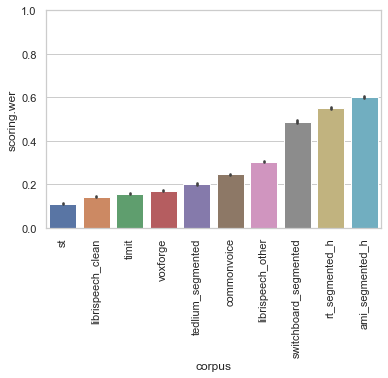

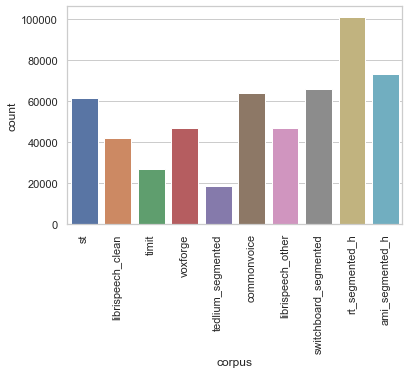

In [79]:
### Corpus volume and mean wer
from numpy import mean
mean_wer_corpus = df.groupby(['corpus']) \
       .agg(count=('scoring.wer', 'size'), mean_wer=('scoring.wer', 'mean')) \
       .reset_index()
order = mean_wer_corpus.sort_values('mean_wer')['corpus']

import seaborn as sns
sns.set(style="whitegrid")

ax = sns.barplot(x="corpus", y="scoring.wer", data=df, estimator=mean, order = order)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

ax = sns.countplot(x="corpus", data=df, order = order)
plt.xticks(rotation=90)
plt.show()

## Boxplots - WER per corpus and configuration

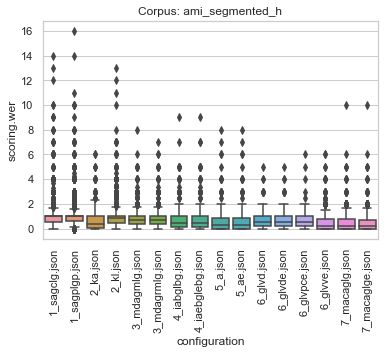

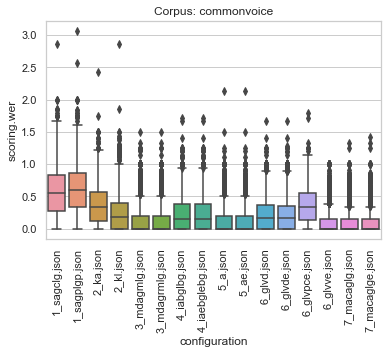

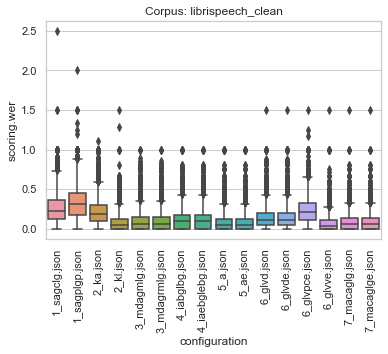

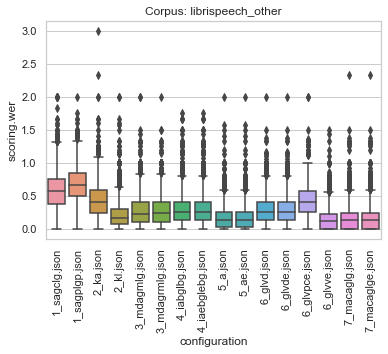

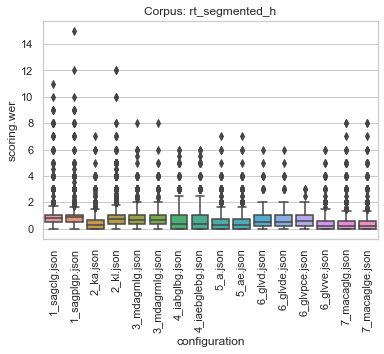

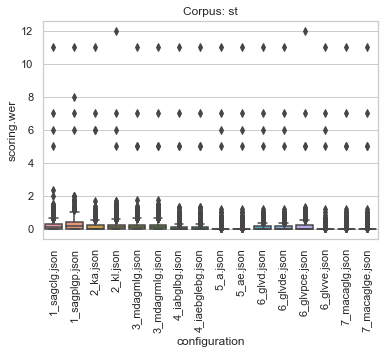

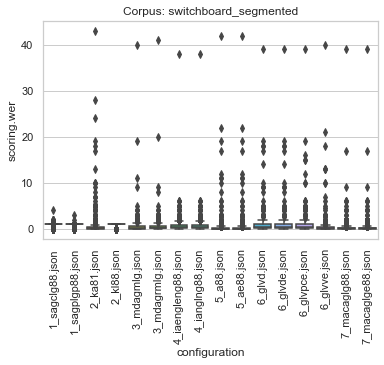

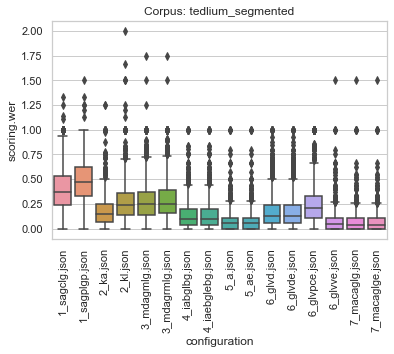

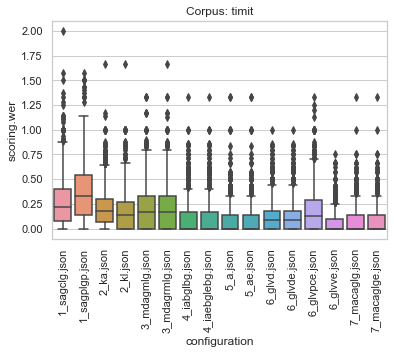

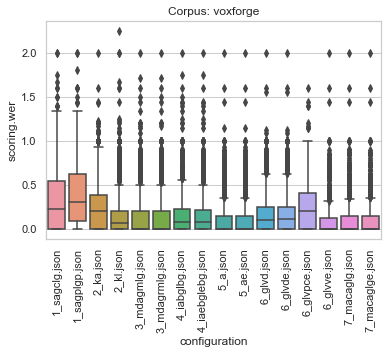

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
corpus = df['corpus'].unique()
for element in corpus:
    data = df[df['corpus']==element]
    ax = sns.boxplot(x="configuration", y="scoring.wer", data=data)
    ax.set_title("Corpus: " + element)
    plt.xticks(rotation=90)
    plt.show()
None

In [82]:
# Export results - mean wer and volume per corpus and configuration
mean_wer_agg = df.groupby(['corpus','configuration']) \
       .agg(count=('scoring.wer', 'size'), mean_wer=('scoring.wer', 'mean')) \
       .reset_index()
mean_wer_agg = mean_wer_agg.sort_values('mean_wer')
mean_wer_agg.to_csv('./data/mean_wer_on_raw_data.csv')

## Bar plots - WER per corpus and configuration

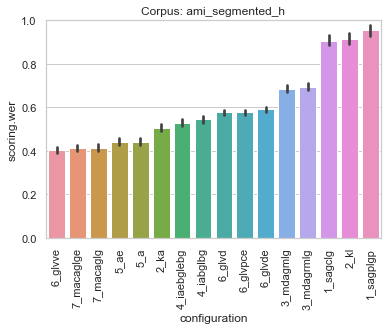

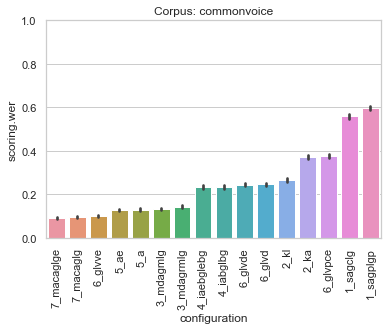

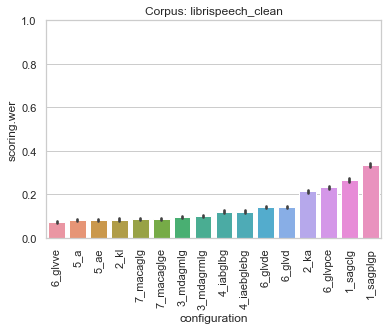

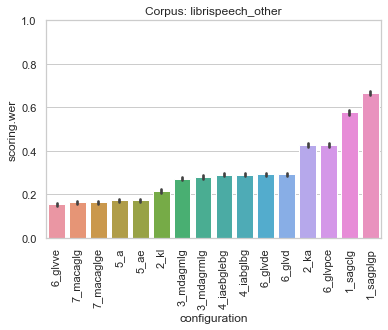

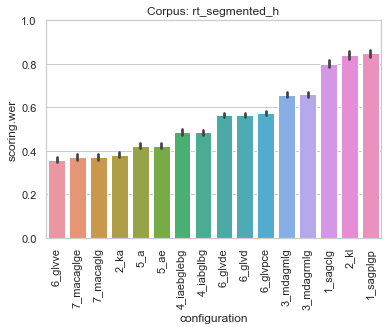

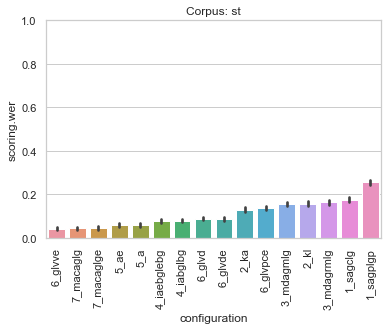

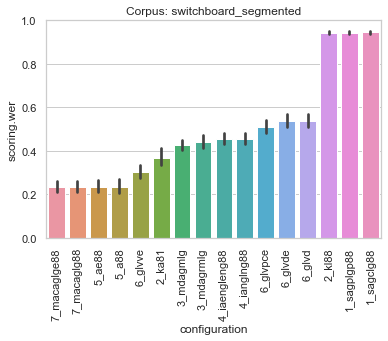

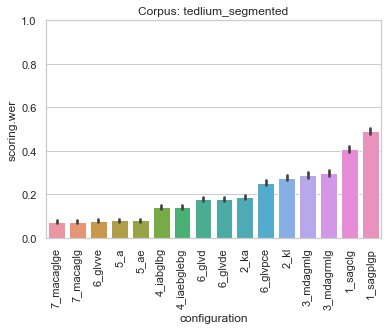

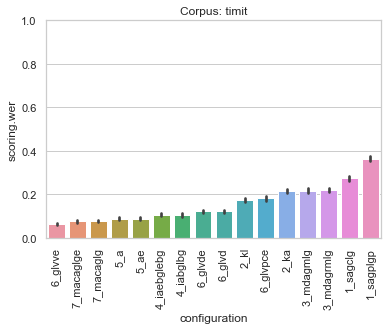

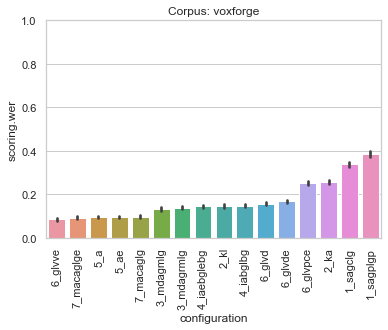

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
sns.set(style="whitegrid")

corpus = df['corpus'].unique()

for element in corpus:
    order = mean_wer_agg[mean_wer_agg['corpus'] == element]['configuration']
    data = df[df['corpus']==element]
    ax = sns.barplot(x="configuration", y="scoring.wer", data=data, estimator = mean, order = order)
    ax.set_title("Corpus: " + element)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
None

In [96]:
# how come we have such high WER for switchboard?
# reason: ref very short and hyp very long
df[df['corpus']=='switchboard_segmented'][['identifier', 'file', 'reference.text', 'hypothesis.text', 'scoring.wer']].sort_values(['scoring.wer'], ascending = False)

,identifier,file,reference.text,hypothesis.text,scoring.wer
2880,sw2165A-ms98-a-0049,switchboard_segmented__2_ka81.json,yeah,yeah and it's funny because people call things differently in different areas um my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like um uh we called them all hoagie,43.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__5_ae88.json,yeah,yeah and it's funny because people call things differently in different areas um my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like um we called them all hoagies,42.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__5_a88.json,yeah,yeah and it's funny because people call things differently in different areas um my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like um we called them all hoagies,42.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__3_mdagrmlg.json,yeah,it yeah and it's funny because people call things differently in different areas um my parents grip a lot in the philadelphia area i was very young we lived there but you call things differently like um we call them all hogs,41.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__3_mdagmlg.json,yeah,it eats funny because people call things differently in different areas um my parents grip a lot in the philadelphia are i was very young we lived there but i call things differently like um we call them all hogs,40.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__6_glvve.json,yeah,yeah and it's funny because people call things differently in different areas my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like we call them all hoagie,40.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__6_glvd.json,yeah,it's funny because people call things differently in different areas my parents grew up a lot in the philadelphia area i was very young when we left there but you call things differently like we called him a hoagie,39.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__7_macaglge88.json,yeah,people call things differently in different areas uh my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like uh uh we called them all hoagies,39.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__7_macaglg88.json,yeah,people call things differently in different areas uh my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like uh uh we called them all hoagies,39.0
2880,sw2165A-ms98-a-0049,switchboard_segmented__6_glvpce.json,yeah,yeah it's funny because people call things differently and different areas my parents grew up a lot in the philadelphia area i was very young when we lived there but you call things differently like we called him all hoagies,39.0


## Examine the distribution of WER per configuration
- different configurations have different variations of mean WER
- reexamine the distribution after cleaning

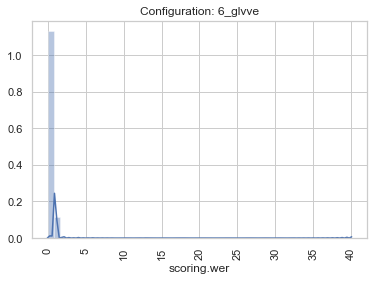

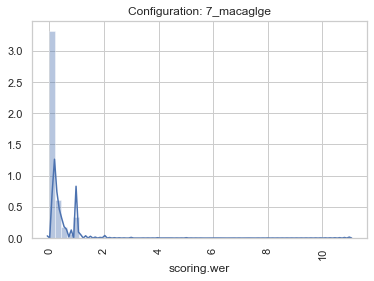

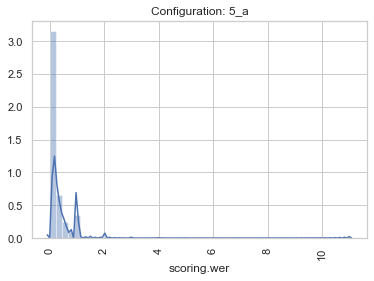

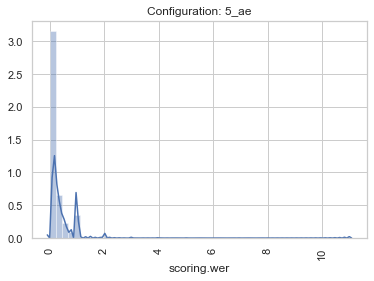

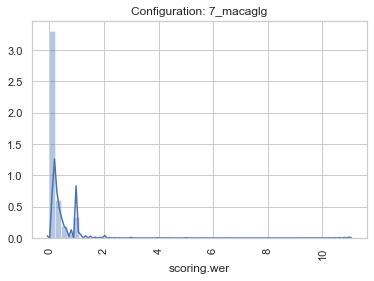

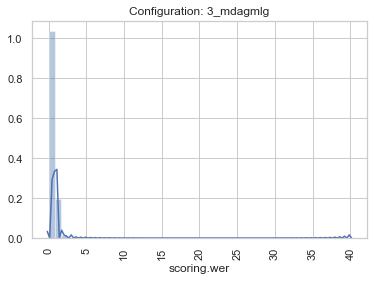

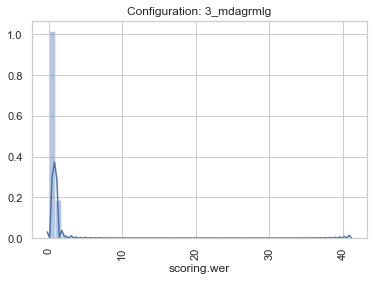

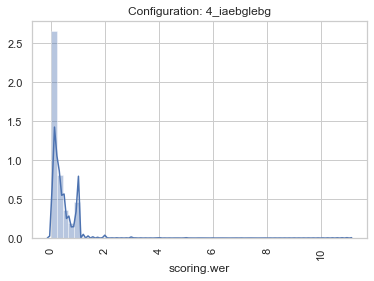

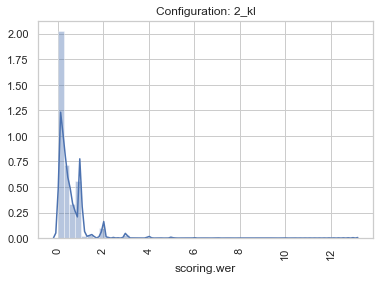

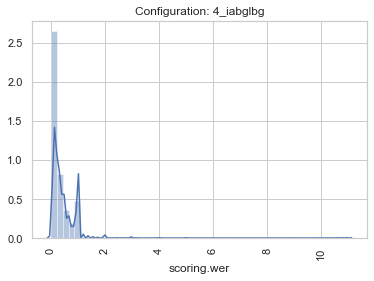

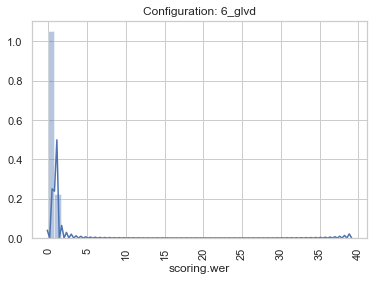

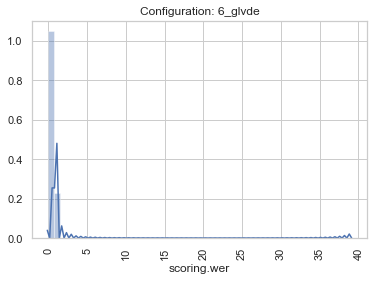

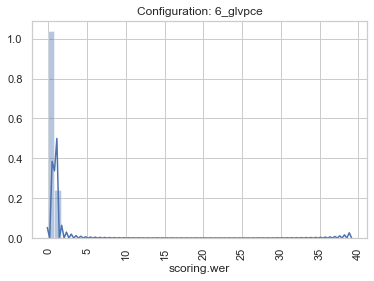

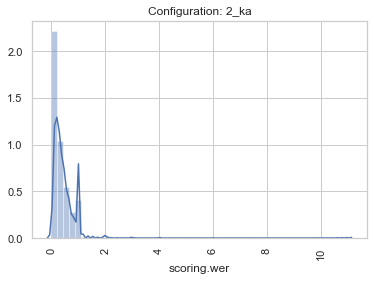

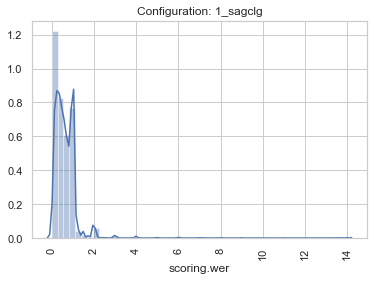

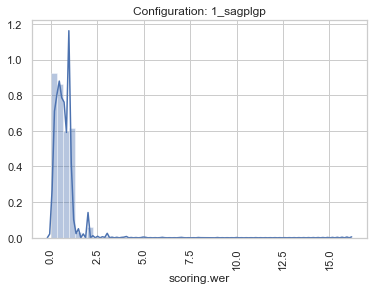

In [103]:
import seaborn as sns
sns.set(style="whitegrid")
for element in order:
    ax = sns.distplot(df[df['configuration']==element]["scoring.wer"])
    ax.set_title("Configuration: " + element)
    plt.xticks(rotation=90)
    plt.show()
None

# Special characters - do references contain any?
- why does thre reference still have characters like ":", '"'.? 
- In cases like **REF**:"presently" his water brother said breathlessly, **HYP**:presently his water brother said breathlessly, the scoring wer (0.166667) is missleading, it should be 0. 
- We will clean these and recompute the WER.

In [7]:
from functions import check_special_characters

cols = ['identifier', 'file', 'reference.text', 'hypothesis.text', 'scoring.wer']
df_special_characters_reference = check_special_characters(df, 'reference.text')[cols]
df_special_characters_reference.shape

(4160, 5)

In [8]:
df_special_characters_reference

,identifier,file,reference.text,hypothesis.text,scoring.wer
24,ES2010c_D_1037_312,ami_segmented_h__1_sagclg.json,two double a_s,ooh double a's,0.666667
48,EN2002d_A_1065_862,ami_segmented_h__1_sagclg.json,c_,spain,1.000000
88,EN2004a_A_1220_352,ami_segmented_h__1_sagclg.json,what's the c_ is that a,both her feet if air,1.000000
98,ES2005c_A_631_938,ami_segmented_h__1_sagclg.json,then d blind don't watch t_v_ they do,i do that flying a watch tv he had a month i,1.375000
148,TS3012d_D_1924_678,ami_segmented_h__1_sagclg.json,r_ three c_,our friends he,1.000000
...,...,...,...,...,...
1001,JMG0_SI1811,timit__7_macaglge.json,"""presently"" his water brother said breathlessly",presently his water brother said breathlessly,0.166667
1244,MAF0_SI829,timit__7_macaglge.json,what it does: stimulates rumen activity,what it does stimulates room in activity,0.500000
1515,WJG0_SI1754,timit__7_macaglge.json,he said: the crazy fool half aloud,he said the crazy fool half allowed,0.285714
1673,KMS0_SI860,timit__7_macaglge.json,these include: leaves of absences illnesses an...,these include leaves of absences illnesses and...,0.125000


In [9]:
df_special_characters_reference.to_csv('/Users/oanaserban/propulsion_final_project/spinningbytes/data/df_special_characters_reference.csv')

# References with less than 5 words
- they can be uninteresting for the analysis. How many are they? 25%

In [24]:
df_clean = df[df['reference.text'].apply(lambda x: x.count(" ") >= 4)]
print('references with less than 5 words:', (df.shape[0] - df_clean.shape[0]) / df.shape[0])

references with less than 5 words: 0.2542591183185996


# Upper cases in reference or hypothesis

In [57]:
# 135.808 times ref is uppercase. Important - wer is not affected
df[df['reference.text'].apply(lambda x: x.isupper()) == True][['identifier', 'file', 'reference.text', 'hypothesis.text', 'scoring.wer']]

# 30.391 times ref is uppercase. Important - wer is not affected
df[df['hypothesis.text'].apply(lambda x: x.isupper()) == True][['identifier', 'file', 'reference.text', 'hypothesis.text', 'scoring.wer']]

,identifier,file,reference.text,hypothesis.text,scoring.wer
0,ES2010b_D_1504_166,ami_segmented_h__2_kl.json,wait,WINNIE,1.000000
1,IS1005b_D_2052_605,ami_segmented_h__2_kl.json,yeah,NANCE,1.000000
2,IB4001_C_878_528,ami_segmented_h__2_kl.json,maybe that would be good,MAYBE THAT WOULD BE GOOD,0.000000
4,ES2016c_C_1315_898,ami_segmented_h__2_kl.json,mm,AH,1.000000
5,IN1001_A_1425_55,ami_segmented_h__2_kl.json,well i just i i i it's i think this is,WELL I JUST E E IS I THINK THIS IS TOO,0.454545
...,...,...,...,...,...
2924,KenBloom_20071122_tid__a0472,voxforge__2_kl.json,HE IS TOO KEENLY INTELLIGENT TOO SHARPLY SENSI...,HE IS TOO KEENLY INTELLIGENT TOO SHARPLY SENSI...,0.272727
2925,douglaid_20080203__vf3_01,voxforge__2_kl.json,WHAT IF SHE DID NOT COME TO THE ROCK\n,WHAT IF SHE DID NOT COME TO THE ROCK,0.000000
2926,douglaid_20080203__vf3_11,voxforge__2_kl.json,HIS BLOOD GREW HOT WITH RAGE AT THE THOUGHT\n,BUT HIS BLOOD GREW HOT WITH RAGE AT THE THOUGHT,0.111111
2927,douglaid_20080203__vf3_21,voxforge__2_kl.json,YOU YOU WOULD NOT KEEP THE TRUTH FROM ME\n,YOU YOU WOULD NOT CAPE THE TRUTH FROM ME,0.111111
